# Exercise 4 [10.0]

**_DISCLAIMER:_** The notation used in this exercise follows the one of the Probabilistic Robotics book (refer to Chapter 5.4 in case you have doubts).

## 4.1 Inverse motion model [2.0]

The odometry model uses the _relative motion information_. The odometry readings are $u_t = [{\overline{x}}_{t-1} , {\overline{x}}_{t}]$, where $\overline{x}_{t-1}$ and  $\overline{x}_t$ are poses in a robot-internal coordinate frame (different from the map).

The function `inverse_motion_model` takes as input an odometry reading $u_t$ that consist in:

- the initial pose of the robot in the odometry coordinate frame $\overline{x}_{t-1} = [\overline{x},\overline{y},\overline{\theta}]$
- the estimated pose of the robot in the odometry coordinate frame $\overline{x}_t = [\overline{x}',\overline{y}',\overline{\theta}']$

The output is the relative motion $\delta_{rot1}, \delta_{trans}, \delta_{rot2}$.

Implement the function `inverse_motion_model` and verify that it is correct for some test input. 

In [2]:
import ex4 as ex
import matplotlib.pyplot as plt
import numpy as np

ex.inverse_motion_model([0.0 ,0.0 ,0.0], [0.5, 0.0 ,np.pi/2])

(0.0, 0.5, 1.5707963267948966)

## 4.2 Odometry-based motion model [3.0]

The function `motion_model` computes the posterior $p(x_t | u_t, x_{t-1})$ from odometry readings.

This function takes as input:

- the initial pose of the robot $x_{t-1} = [x,y,\theta]$ _(**map** coordinate frame)_
- the hypothesized (or query) final pose $x_{t} = [x', y', \theta']$ _(**map** coordinate frame)_
- the odometry readings $u_t = [\overline{x}_{t-1} \overline{x}_t]$ _(**odometry** coordinate frame)_
- the noise parameters $\mathbf{\alpha} = [\alpha_1, \alpha_2, \alpha_3, \alpha_4]$

The output is the probability $p(x_t | u_t, x_{t-1})$

Assume that a robot starts at pose $x_0 = [2.0, 3.0, 0.0]$ in the map frame and moves according to a motion model with $\mathbf{\alpha} = [1.0, 1.0, 0.01, 0.01]$.

The robot excecutes one motion command and the odometry readings are:

1. $\overline{x}_0 = [0.0 , 0.0 , 0.0   ]$
2. $\overline{x}_1 = [0.5 , 0.0 , \pi/2 ]$

Implement the `motion_model` function and verify that it is correct for some test input. **[1.0]**

---

Consider a 150x150 grid map the world with a resolution of 0.01, centered in the original position of the robot.

Plot the posterior $p(x_t | u_t, x_{t-1})$ for all possible $[x, y]$ values from the grid. **[2.0]**

**Note that** the query input is a position, not a pose. Therefore, to plot the posterior belief over the gridmap, you can assume the term $\hat{\delta}_\mathrm{rot2}$ to be zero and, for each position, integrate over all possible orientations. This can be implemented by considering $p_3 = 1.0$ in the equations. 

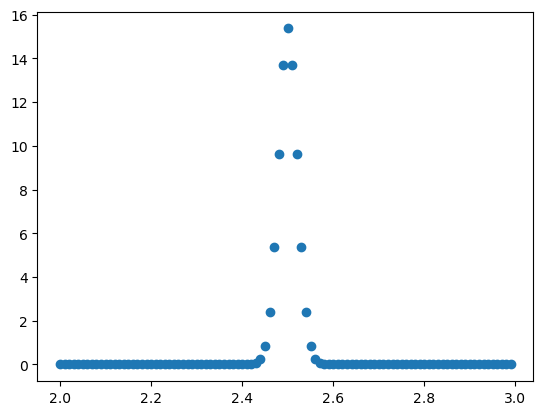

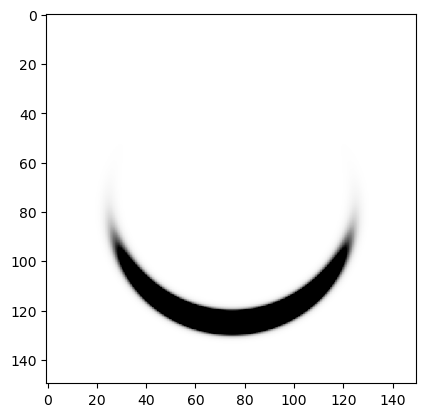

In [3]:
odom = [[0.0 , 0.0 , 0.0], [0.5, 0.0, np.pi/2]]
prev_pose = [2, 3, 0]
alpha = [1.0, 1.0, 0.01, 0.01]
q = []
pl = []
for i in range(200,300):
    cur_pose = [i/100,3,0]
    p = ex.motion_model(cur_pose, prev_pose, odom, alpha,normal=False)
    pl.append(p)
    q.append(i/100)
plt.scatter(q,pl)
plt.show

gridmap = np.zeros((150,150))
res = 0.01
for i in range(gridmap.shape[0]):
    for j in range(gridmap.shape[1]):
        cur_pose = ex.map2world(i,j,prev_pose,gridmap,res)
        gridmap[i][j] = ex.motion_model(cur_pose, prev_pose, odom, alpha,normal=False)
        
ex.plot_gridmap(gridmap)

## 4.3 Sample odometry motion model [2.0]

The `motion_model` requires high computation complexity and does not scale well to large real-world environments. 

One effective approach to approximate $p(x_t | u_t, x_{t-1})$ is to use **sampling**.

The `sample_motion_model` function defines the sampling-based odometry motion model. 

This function takes as input:

- the initial pose of the robot $x_{t-1} = [x,y,\theta]$ _(**map** coordinate frame)_
- the odometry readings $u_t = [\overline{x}_{t-1} \overline{x}_t]$ _(**odometry** coordinate frame)_
- the noise parameters $\mathbf{\alpha} = [\alpha_1, \alpha_2, \alpha_3, \alpha_4]$

The output is a new (sampled) pose predicted by the motion model.

Implement the `sample_motion_model` function and verify that it is correct for some test input. 

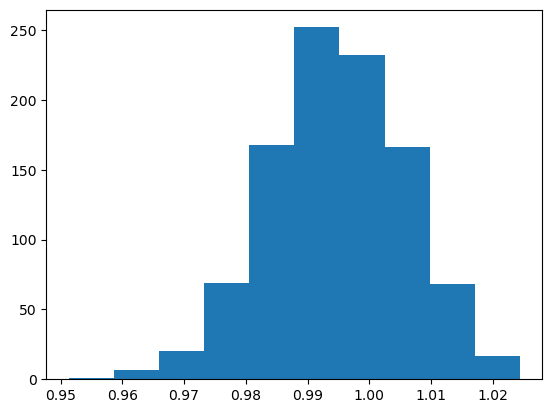

In [4]:
import math
def sample_motion_model(x_init,u_t,alpha):
    rot1, trans, rot2 = inv_motion_model(u_t)

    rot1_hat = rot1 + sample_distribution(alpha[0]* abs(rot1)+ alpha[1]*trans)
    trans_hat = trans + sample_distribution(alpha[2]*trans + alpha[3] * (abs(rot1)+ abs(rot2)))
    rot2_hat  = rot2 + sample_distribution(alpha[0] * abs(rot2)  + alpha[1] * trans)

    x_new = x_init[0] + trans_hat * np.cos(x_init[2]+rot1_hat)
    y_new = x_init[1] + trans_hat * np.sin(x_init[2]+rot1_hat)
    theta_new = x_init[2] + rot1_hat + rot2_hat

    return x_new,y_new,theta_new

def inv_motion_model(u_t):
    trans = math.sqrt((u_t[1][0]-u_t[0][0])**2 + (u_t[1][1]-u_t[0][1])**2)
    rot1  = math.atan2((u_t[1][1]-u_t[0][1]),(u_t[1][0]-u_t[0][0])) - u_t[0][2]
    rot2  = u_t[1][2] - u_t[0][2] - rot1

    return rot1, trans, rot2

def sample_distribution(std):
    return ((math.sqrt(6)/2)*(np.random.uniform(-std,std)+np.random.uniform(-std,std)))


x = np.array([0.0,0.0,0.0])
alpha = np.array([0.1,0.1,0.01,0.01])
u = np.array([[0.0,0.0,0.0],[1.0,0.0,0.0]])
x_n= []
for i in range(1000):
    x_new,y_new,z_new = sample_motion_model(x, u, alpha)
    x_n.append(x_new)
x_n = np.array(x_n)


plt.hist(x_n)
plt.show()

## 4.4 Evaluate sample odometry motion model  [3.0]

Assume that a robot starts at pose $x_0 = [2.0, 3.0, 0.0]$ in the map frame and moves according to a motion model with $\mathbf{\alpha} = [0.1, 0.1, 0.01, 0.01]$.

The robot obtains the following odometry readings:

1. $\overline{x}_0 = [0.0 , 0.0 , 0.0   ]$
2. $\overline{x}_1 = [0.5 , 0.0 , \pi/2 ]$
3. $\overline{x}_2 = [0.5 , 0.5 , 0.0   ]$
4. $\overline{x}_3 = [1.0 , 0.5 , 0.0   ]$
5. $\overline{x}_4 = [1.0 , 1.5 , \pi/2 ]$
6. $\overline{x}_5 = [1.0 , 2.5 , \pi/2 ]$

Evaluate the `sample_motion_model` by considering 1000 samples and plot the resulting positions for each sample in one unique plot.

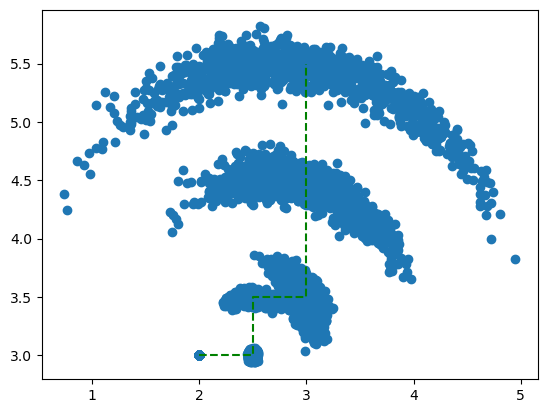

In [5]:
commands = np.array([[0.0,0.0,0.0],[0.5,0.0,math.pi/2],[0.5,0.5,0.0],[1.0,0.5,0.0],[1.0,1.5,math.pi/2],[1.0,2.5,math.pi/2]])
alpha = np.array([0.1,0.1,0.01,0.01])
x_initials = np.array([0.0,0.0,0.0])
n_samples = 1000

samples = np.array([2.0,3.0,0.0]*1000).reshape((1000,3))

for i in range(1,len(commands)):
        
        x_init = np.array([2.0,3.0,0.0]) + np.array(commands[i-1])
        
        x_initials = np.vstack((x_initials,x_init))
        
        count = (i-1) * 1000
        
        u_t = np.array([commands[i-1], commands[i]])
      
        for j in range(1000):
                 
                 x_new,y_new,theta_new = sample_motion_model(samples[count + j],u_t,alpha)
                 pose = np.array([x_new,y_new,theta_new])
                 samples = np.vstack((samples,pose.T))
              

x_initials = np.vstack((x_initials,[3.0,5.5,0.0]))

plt.plot(x_initials[1:,0], x_initials[1:,1], "--g")
plt.scatter(samples[:,0], samples[0:,1])
plt.show()